# Text classification with Huggingface transformers

Other useful materials:
-  https://karpathy.github.io/2019/04/25/recipe/

In [2]:
from datasets import list_datasets

In [4]:
list_datasets()[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [5]:
from datasets import load_dataset

Let's explore the `emotion` dataset

In [8]:
emotions = load_dataset('SetFit/emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/SetFit--emotion-ddb0f0516f8def09/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Note that `load_dataset` can also be used to load local datasets.

In [9]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

We can get dataset splits with itemgetter syntax

In [10]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [11]:
type(train_ds)

datasets.arrow_dataset.Dataset

This is an Arrow dataset

In [13]:
len(train_ds)

16000

In [14]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [15]:
train_ds.column_names

['text', 'label', 'label_text']

In [16]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

In [17]:
train_ds[:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3],
 'label_text': ['sadness', 'sadness', 'anger']}

We can also slice particular columns

In [19]:
train_ds['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

## From `Dataset`s to `DataFrame`s

Huggingface transformers provides an API to convert the *output* of a `Dataset` object to a Pandas `DataFrame`, whilst retaining the underlying data format of an Arrow table. This can be useful for e.g. visualisation.

In [20]:
import pandas as pd

In [23]:
emotions.set_format(type='pandas')
df = emotions['train'][:]

In [24]:
df

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Visualize the class distribution

<AxesSubplot:>

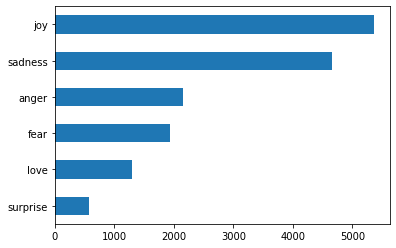

In [27]:
df['label_text'].value_counts(ascending=True).plot.barh()

To deal with imbalance, we can e.g.:
- Undersample over-represented classes
- Oversample under-represented classes
- Reweight the loss with the inverse category frequency

Be sure to only under/over-sample once you've performed a test/train split.

## Visualise token length

In [31]:
df['n_words'] = df['text'].str.split(' ').apply(len)

<AxesSubplot:title={'center':'n_words'}, xlabel='label_text'>

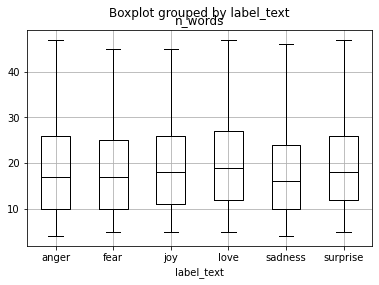

In [42]:
df.boxplot(column='n_words', by='label_text', showfliers=False, whis=(2.5, 97.5), color='black')

No substantial difference in the distribution of lengths

In [43]:
df['n_words'].describe()


count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: n_words, dtype: float64

The maximum number of words is well below DistilBERT's maximum context size.

When we're done with EDA, we can reset the output format.

In [44]:
emotions.reset_format()

## Tokenization

Character tokenization requires a model to learn how to form words from characters, putting a large burden on the language model. Word tokenization can result in very large vocabularies once you take declinations (?), conjugations, or misspellings into account. Subword tokenization is a more commonly-used middle-ground, and is typically learned from the corpus

We can load the tokenizer associated with a pre-trained model as follows:

In [1]:
from transformers import AutoTokenizer

In [3]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]